## Setup Environment

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install transformers
! pip install pycaret
! pip install squarify
! pip install nltk

In [2]:
## Load Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m3ni3w\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Abanoub Abdelmalak\OMSCS\CS7643_DL\Group Project\cs7643-groupproject
(39409, 3)
                                                text  label Target
0  republican committee pass bill would prohibit ...      0   True
1  trump treasury candidate bank accuse discrimin...      1   Fake
2  guess behind sicken ad show boy bully dad vote...      0   True
3  michigan treasurer call quick action detroit s...      1   Fake
4  clinton urge renew fight value washington reut...      1   Fake


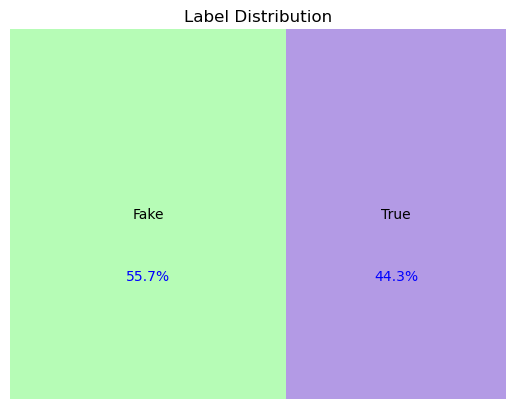

There are no null values in the dataset.


In [3]:
import numpy as np
import pandas as pd
import pycaret
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import transformers
from transformers import AutoModel, BertTokenizerFast, GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, GPT2LMHeadModel, GPT2TokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import squarify

# specify GPU
device = torch.device("cuda")
nltk.download('stopwords')

# Set Working Directory
# %cd /content/drive/My Drive/Colab Notebooks/DL-Project
%cd "C:\Abanoub Abdelmalak\OMSCS\CS7643_DL\Group Project\cs7643-groupproject\"


data = pd.read_csv('./Data/final_fake_news.csv', delimiter=';')


true_data = pd.read_csv('./Data/True_original.csv')
fake_data = pd.read_csv('./Data/Fake_original.csv')
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)
original_data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

data["Target"] = data["label"].apply(lambda x: "Fake" if x == 1 else "True")

print(data.shape)
print(data.head())

# True/Fake to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']


label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
labels = ['Fake', 'True']
colors = ['#98FB98', '#9370DB']

fig, ax = plt.subplots()
squarify.plot(sizes=label_size, label=labels, color=colors, alpha=0.7, ax=ax)

plt.title('Label Distribution')
plt.axis('off')

for i, rect in enumerate(ax.patches):
    percentage = label_size[i] / sum(label_size) * 100
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + rect.get_height() / 3
    plt.text(x=x, y=y, s=f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='blue')

plt.show()

# Check if there are null values
if data.isnull().values.any():
    print("There are null values in the dataset.")
else:
    print("There are no null values in the dataset.")
    
    
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Creating a new model

The model is a Custom Multiheaded Transformer. The reason behind the architecture is to allow the transformer to work in the sense where each head is responsible for analyzing different segments of the sentence. Then allow the heads are mashed together using softmax function.


### Load pretrained GPT Model

In [6]:
# Load BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


### Prepare Input Data

Median: 215.0
Mode: 245
Mean: 237.51015007612557


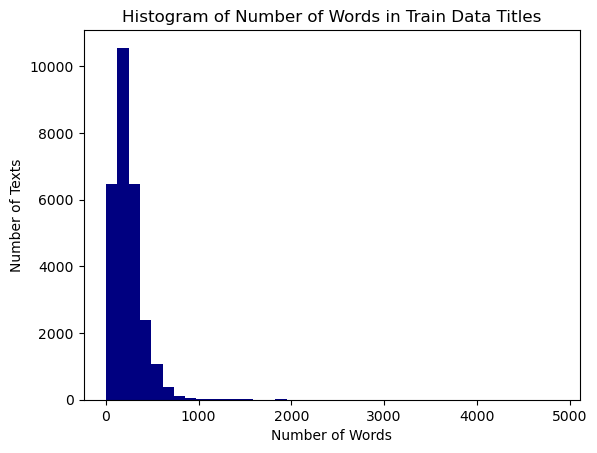

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Calculate the number of words in each title
seq_len = [len(title.split()) for title in train_text]

plt.hist(seq_len, bins=40, color='navy')

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.title('Histogram of Number of Words in Train Data Titles')

# Calculate the median
median_value = np.median(seq_len)
print("Median:", median_value)

# Calculate the mode
mode_value = stats.mode(seq_len)
print("Mode:", mode_value.mode[0])

# Calculate the mean
mean_value = np.mean(seq_len)
print("Mean:", mean_value)

# Show the plot
plt.show()


In [9]:
# Set max title length
MAX_LENGHT = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
# Freeze the parameters of the pre-trained BERT model
for param in bert.parameters():
    param.requires_grad = True

### Define Model Architecture

In [16]:
# Build a full transformer model using Inception as the encoder.
from torch import nn
from torchvision.models import Inception3
from torch.nn import Transformer
import torch.nn.functional as F
import torch


import math
import os
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class InceptionTransformer(nn.Module):
    """ Build a model using Inception and transformer.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        # self.inception = Inception3(num_classes=config["d_model"])
        # self.inception.fc = nn.Linear(2048, config["d_model"])
        # self.transformer = TransformerTranslator(config.input_size, config.output_size, config.hidden_dim, config.num_heads, config.dim_feedforward, config.max_length, config.device)
        self.transformer = Transformer(d_model=config["d_model"], nhead=config["n_heads"], num_encoder_layers=config["d_model"], num_decoder_layers=config["d_model"], dim_feedforward=config["dim_feedforward"], dropout=config["dropout"], activation=config["activation"], custom_encoder=None, custom_decoder=None)
        
    def forward(self, x, mask=None):
        if mask is None:
            mask = torch.ones(x.shape[0], x.shape[1]).to(self.config["device"])
        # x = x.unsqueeze(1)
        # print("input shape:", x.shape)
        # x = self.inception(x)
        # x = x.permute(1, 0, 2)
        x = self.transformer(x, x, tgt_mask=mask)
        # x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        return x


class InceptionMultiHeadTransformer(nn.Module):
    """ Build a model using Inception and multi-head transformer.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = InceptionTransformer(config)
    
    def forward(self, inputs, mask):
        """ Forward pass.
        
        Args:
            inputs: A tensor of shape (batch_size, seq_len, input_size).
            mask: A tensor of shape (batch_size, seq_len).
        
        Returns:
            outputs: A tensor of shape (batch_size, seq_len, output_size).
        """
        outputs = self.transformer(inputs, mask)
        outputs = nn.functional.log_softmax(outputs, dim=2)
        return outputs


import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError as e:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""") from e
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except BaseException as e:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or '
                              'lower.') from e
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)


def seed_torch(seed=0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


class TransformerTranslator(nn.Module):
    """
    A single-layer Transformer which encodes a sequence of text and
    performs binary classification.

    The model has a vocab size of V, works on
    sequences of length T, has an hidden dimension of H, uses word vectors
    also of dimension H, and operates on minibatches of size N.
    """

    def __init__(self, input_size, output_size, device, hidden_dim=128, num_heads=2, dim_feedforward=2048, dim_k=96, dim_v=96, dim_q=96, max_length=43):
        """
        :param input_size: the size of the input, which equals to the number of words in source language vocabulary
        :param output_size: the size of the output, which equals to the number of words in target language vocabulary
        :param hidden_dim: the dimensionality of the output embeddings that go into the final layer
        :param num_heads: the number of Transformer heads to use
        :param dim_feedforward: the dimension of the feedforward network model
        :param dim_k: the dimensionality of the key vectors
        :param dim_q: the dimensionality of the query vectors
        :param dim_v: the dimensionality of the value vectors
        """
        super(TransformerTranslator, self).__init__()
        assert hidden_dim % num_heads == 0

        self.num_heads = num_heads
        self.word_embedding_dim = hidden_dim
        self.hidden_dim = hidden_dim
        self.dim_feedforward = dim_feedforward
        self.max_length = max_length
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.dim_q = dim_q

        seed_torch(0)
        
        # initialize word embedding layer
        self.embeddingL = nn.Embedding(input_size, hidden_dim).to(device)
        # initialize positional embedding layer
        self.posembeddingL = nn.Embedding(max_length, hidden_dim).to(device)

        # Head #1
        self.k1 = nn.Linear(self.hidden_dim, self.dim_k).to(device)
        self.v1 = nn.Linear(self.hidden_dim, self.dim_v).to(device)
        self.q1 = nn.Linear(self.hidden_dim, self.dim_q).to(device)

        # Head #2
        self.k2 = nn.Linear(self.hidden_dim, self.dim_k).to(device)
        self.v2 = nn.Linear(self.hidden_dim, self.dim_v).to(device)
        self.q2 = nn.Linear(self.hidden_dim, self.dim_q).to(device)

        self.softmax = nn.Softmax(dim=2).to(device)
        self.attention_head_projection = nn.Linear(
            self.dim_v * self.num_heads, self.hidden_dim).to(device)
        self.norm_mh = nn.LayerNorm(self.hidden_dim).to(device)

        self.feedforward = nn.Sequential(
            nn.Linear(self.hidden_dim, self.dim_feedforward),
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.hidden_dim)).to(device)
        self.norm_ff = nn.LayerNorm(self.hidden_dim).to(device)
        self.output_layer = nn.Linear(hidden_dim, output_size).to(device)
        self.dropout = nn.Dropout(0.5).to(device)
        self.to(device)

    def forward(self, inputs):
        """
        This function computes the full Transformer forward pass.
        Put together all of the layers you've developed in the correct order.

        :param inputs: a PyTorch tensor of shape (N,T). These are integer lookups.

        :returns: the model outputs. Should be scores of shape (N,T,output_size).
        """
        embeds = self.embed(inputs)

        hidden_states = self.multi_head_attention(embeds)
        outputs = self.feedforward_layer(hidden_states)
        scores = self.final_layer(self.dropout(outputs))
        return scores

    def embed(self, inputs):
        """
        :param inputs: intTensor of shape (N,T)
        :returns embeddings: floatTensor of shape (N,T,H)
        """
        # Word Embedding
        #print(f"DEBUG: inputs size:P{inputs.shape}")
        word_emb = self.embeddingL(inputs)
        # Positional Encoding
        positions = torch.arange(
            self.max_length, device=self.device).unsqueeze(0)
        pos_encode = self.posembeddingL(positions)
        x = pos_encode + word_emb
        return x

    def multi_head_attention(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,H)

        Traditionally we'd include a padding mask here, so that pads are ignored.
        This is a simplified implementation.
        """
        # Multi-head Attention
        k1 = self.k1(inputs)
        v1 = self.v1(inputs)
        q1 = self.q1(inputs)
        k2 = self.k2(inputs)
        v2 = self.v2(inputs)
        q2 = self.q2(inputs)
        z1 = torch.bmm(q1, k1.transpose(1, 2)) / np.sqrt(self.dim_k)
        z1 = torch.softmax(z1, dim=-1)
        z11 = torch.bmm(z1, v1)
        z2 = torch.bmm(q2, k2.transpose(1, 2)) / np.sqrt(self.dim_k)
        z2 = torch.softmax(z2, dim=-1)
        z22 = torch.bmm(z2, v2)
        z = torch.cat((z11, z22), dim=-1)
        z = self.attention_head_projection(z)
        z = self.norm_mh(z + inputs)
        return z

    def feedforward_layer(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,H)
        """
        outputs = self.feedforward(inputs)
        outputs = self.norm_ff(outputs + inputs)
        return outputs

    def final_layer(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,V)
        """
        outputs = self.output_layer(inputs)
        return outputs
    
config = {'n_layers': 2,
          'n_heads': 2,
          'd_model': 768,
          'd_ff': 768,
          'dropout': 0.2,
          'activation': 'gelu',
          'max_len': MAX_LENGHT,
          'vocab_size': len(tokenizer),
          'bos_token': tokenizer.bos_token_id,
          'eos_token': tokenizer.eos_token_id,
          'pad_token': tokenizer.pad_token_id,
          'mask_token': tokenizer.mask_token_id,
          'layer_norm_eps': 1e-5,
          'n_segments': 2,
          'output_attentions': False,
          'output_hidden_states': False,
          'output_past': True,
          'torchscript': False,
          'use_bfloat16': False,
          'pruned_heads': {},
          'is_decoder': False,
          'add_cross_attention': False,
          'tie_word_embeddings': True,
          'is_encoder_decoder': False,
          'use_cache': True,
          'gradient_checkpointing': False,
          'position_embedding_type': 'absolute',
          'return_dict': True,
          "dim_feedforward": 2048,
            }

# Citation: https://huggingface.co/transformers/_modules/transformers/models/gpt2/modeling_gpt2.html#GPT2LMHeadModel
# model = InceptionMultiHeadTransformer(config=config)
# model = TransformerModel(ntoken=config["vocab_size"], d_model=config["d_model"], nhead=config["n_heads"], d_hid=config["d_ff"], nlayers=config["n_layers"], dropout=config["dropout"])
# model = TransformerModel(ntoken=config["vocab_size"], ninp=config["d_model"], nhead=config["n_heads"], nhid=config["d_ff"], nlayers=config["n_layers"], dropout=config["dropout"])
model = TransformerTranslator(input_size=config["vocab_size"], output_size=config["vocab_size"], device=device, hidden_dim=config["d_model"], num_heads=config["n_heads"], dim_feedforward=config["d_ff"], dim_k=96, dim_v=96, dim_q=96, max_length=config["max_len"])

from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)
# cross_entropy  = nn.NLLLoss()
criterion  = nn.NLLLoss()
epochs = 10

### Define Train & Evaluate Function

In [19]:
from sklearn.metrics import accuracy_score

def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch

    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)

    labels = labels.unsqueeze(1)
    model.zero_grad()

    # preds = model(sent_id, mask)
    preds = model(sent_id)
    preds = preds.unsqueeze(2)

    print(preds.shape, labels.shape)
    # labels = labels.float()

    loss = criterion(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return total_loss, avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    labels = labels.unsqueeze(1)
    with torch.no_grad():
      # preds = model(sent_id, mask)
      preds = model(sent_id)
      preds = preds.unsqueeze(2)
      # labels = labels.float()
      loss = criterion(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss


def find_accuracy(model, dataloader, device, batch_size):
    # Set the model to eval mode to avoid weights update
    model.eval()

    total_accuracy = 0
    for step,batch in enumerate(dataloader):
      batch = [t for t in batch]
      sent_id, mask, labels = batch
      sent_id = sent_id.to(device)
      mask = mask.to(device)
      labels = labels.to(device)
      labels = labels.unsqueeze(1)

      with torch.no_grad():
        # preds = model(sent_id, mask)
        preds = model(sent_id)
        pred = torch.max(preds, 1)

        # translation = translation.mean(1)
        # pred = (translation > 0).int()
        # labels = labels.float()
        # correct_items = ((pred == labels).int()).sum().item()
        # correct_pred += correct_items

        # total_accuracy += ((pred == labels).int()).sum().item()
        labels = labels.transpose(0, 1)

        # print("Predictions:", pred.indices)
        # print("Labels:", labels)
        # print(pred.indices == labels)
        # print(((pred.indices == labels).int()).sum().item())

        acc = ((pred.indices == labels).int()).sum().item()
        total_accuracy +=  acc


    # accuracy = correct_pred / (len(dataloader)*batch_size)
    accuracy = total_accuracy / (len(dataloader)*batch_size)
    return accuracy

# from tqdm import tqdm_notebook

# def train(model, dataloader, optimizer, criterion, scheduler=None, device='cpu'):
#     model.train()

#     # Record total loss
#     total_loss = 0.

#     # Get the progress bar for later modification
#     progress_bar = tqdm_notebook(dataloader, ascii=True)

#     # Mini-batch training
#     for batch_idx, data in enumerate(progress_bar):
#         source = data[0].to(device)
#         mask = data[1].to(device)
#         target = data[2].unsqueeze(1).to(device)
#         translation = model(source, mask)

#         optimizer.zero_grad()
#         # translation = translation.unsqueeze(1)
#         target = target.float()
#         print(translation.shape, target.shape)
#         loss = criterion(translation, target)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
#         optimizer.step()

#         total_loss += loss.item()
#         progress_bar.set_description_str(
#             "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

#     return total_loss, total_loss / len(dataloader)

# def evaluate(model, dataloader, criterion, device='cpu'):
#     # Set the model to eval mode to avoid weights update
#     model.eval()
#     total_loss = 0.
#     with torch.no_grad():
#         # Get the progress bar
#         progress_bar = tqdm_notebook(dataloader, ascii=True)
#         for batch_idx, data in enumerate(progress_bar):
#             source = data[0].to(device)
#             mask = data[1].to(device)
#             target = data[2].unsqueeze(1).to(device)
#             translation = model(source, mask)
#             translation = translation.unsqueeze(1)
#             target = target.float()
#             loss = criterion(translation, target)
#             total_loss += loss.item()
#             progress_bar.set_description_str(
#                 "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

#     avg_loss = total_loss / len(dataloader)
#     return total_loss, avg_loss

# def find_accuracy(model, dataloader, device):
#     # Set the model to eval mode to avoid weights update
#     model.eval()
#     correct_pred = 0
#     with torch.no_grad():
#         # Get the progress bar
#         progress_bar = tqdm_notebook(dataloader, ascii=True)
#         for batch_idx, data in enumerate(progress_bar):
#             source = data[0].to(device)
#             mask = data[1].to(device)
#             target = data[2].unsqueeze(1).to(device)
#             translation = model(source)
#             translation = translation.unsqueeze(1)
#             pred = (translation > 0).int()
#             target = target.float()
#             correct_items = ((pred == target).int()).sum().item()
#             correct_pred += correct_items
#             progress_bar.set_description_str(
#                 "Batch: %d, Correct items: %.4f" % ((batch_idx + 1), correct_items))
#     accuracy = correct_pred / (len(dataloader)*batch_size)
#     return accuracy


### Model training

In [20]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
torch.Size([32, 15, 1, 30522]) torch.Size([32, 1])


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [32, 1]

In [ ]:
#from utils import evaluate, set_seed_nb, unit_test_values, deterministic_init
import matplotlib.pyplot as plt
# input size and output size

#Set hyperparameters
MAX_LENGHT = 15
batch_size = 32
PAD_IDX = 0
output_size = 1
learning_rate = 2e-5
EPOCHS = 10
model_path = 'model_trans.pth'

# Get the vocabulary
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
# Print the size of the vocabulary
print("Vocabulary size: ", len(vocab))

input_size = vocab_size


print(f"DEBUG: device:{device}")
# Model
trans_model = TransformerTranslator(
    input_size, output_size, device, max_length=MAX_LENGHT).to(device)

optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCEWithLogitsLoss()
train_per = []
valid_per = []
train_acc_list = []
val_acc_list = []
lowest_loss = 10000
for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")

    train_loss, avg_train_loss = train(
        trans_model, train_dataloader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(
        trans_model, val_dataloader, criterion, device=device)

    acc_train = find_accuracy(trans_model, train_dataloader, device=device)
    acc_val = find_accuracy(trans_model, val_dataloader, device=device)
    print("Training Loss: %.4f. Validation Loss: %.4f. " %
          (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " %
          (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    print("Training Acc: %.4f. Validation Acc: %.4f. " %
          (acc_train, acc_val))

    if np.exp(avg_val_loss) < lowest_loss:
        torch.save(trans_model.state_dict(), model_path)
        lowest_loss = np.exp(avg_val_loss)
        print("Saved model")

    train_per.append(np.exp(avg_train_loss))
    valid_per.append(np.exp(avg_val_loss))

    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)

    x_dim = list(range(epoch_idx+1))

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.plot(x_dim, train_per, label='train_perplexity')
    ax1.plot(x_dim, valid_per, label='validation_perplexity')
    ax1.set_title('Perplexity vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(x_dim, train_acc_list, label='train_accuracy')
    ax2.plot(x_dim, val_acc_list, label='validation_accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('perplexity_trans.png')

### Model performance

In [ ]:
# load weights of best model
path = 'model_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:

plt.title("Loss")
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


## Fake News Predictions

In [ ]:
# testing on unseen data
unseen_news_text_random = ["A precautionary message that one can catch fire due to hand sanitizer as it has a high amount of alcohol. The message also shows the hands of a lady who after applying sanitizer went near the stove and ended up burning her hands.",  # Fake
                    "A Pentagon study found that people who get the flu vaccine are 36% more likely to get COVID-19.",               # Fake
                    "The total number of confirmed cases of COVID-19 is now 1212 which is the number we report to the World Health Organization. There is no one in New Zealand receiving hospital-level care for COVID-19.",           # True
                    "Our total number of confirmed cases remains at 1205 which is the number we report to the World Health Organization."                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text_random,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds